# Sleep stage classification from polysomnography (PSG) EEG data

Code adapted from https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html

In this notebook, we load 10 samples from the PSG sleep study using the MNE python package: https://mne.tools/stable/index.html. The aim is to do multilable classification of different sleep states from EEG traces.

The first sample will act as test data, the rest of the samples are used training data for a Random Forest (RF) classifier. A very simple training regimen is implemented, wherein the sklearn default parameters are used and training is done on the full training dataset (no cross-validation).

## 1: Load PSG data

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from utils import load_psg_samples, DATA_READERS, eegs_power_band

In [41]:
n_subjects = 10
subject_ids = list(range(n_subjects))
sleep_data_files = fetch_data(subjects=subject_ids, recording=[1])

data_format = "edf"
channel = "eeg"

raw = load_psg_samples(sleep_data_files, DATA_READERS[data_format], picks=channel)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' rec

## 2: Epoch data
Every epoch will be 30 seconds long. For each epoch, an associated sleep-state lable is available.

In [42]:
annotation_desc_2_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}
event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3/4": 3,
    "Sleep stage R": 4,
}

epochs = []
# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
for edf, annotation in raw:
    annotation.crop(annotation[1]["onset"] - (30 * 60), annotation[-2]["onset"] + (30 * 60))
    edf.set_annotations(annotation, emit_warning=False)
    events, _ = mne.events_from_annotations(
        edf, event_id=annotation_desc_2_event_id, chunk_duration=30.0
    )

    tmax = 30.0 - (1.0 / edf.info["sfreq"])  # tmax is included
    epoched = mne.Epochs(
        raw=edf,
        events=events,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
    )
    epochs.append(epoched)

del raw # free up some memory
epochs

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['S

[<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 188
  'Sleep stage 1': 58
  'Sleep stage 2': 250
  'Sleep stage 3/4': 220
  'Sleep stage R': 125>,
 <Epochs |  1103 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 157
  'Sleep stage 1': 109
  'Sleep stage 2': 562
  'Sleep stage 3/4': 105
  'Sleep stage R': 170>,
 <Epochs |  1025 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 128
  'Sleep stage 1': 94
  'Sleep stage 2': 545
  'Sleep stage 3/4': 95
  'Sleep stage R': 163>,
 <Epochs |  952 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 140
  'Sleep stage 1': 61
  'Sleep stage 2': 485
  'Sleep stage 3/4': 57
  'Sleep stage R': 209>,
 <Epochs |  1235 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 200
  'Sleep stage 1': 166
  'Sleep stage 2': 620
  'Sleep stage 3/

In [43]:
epochs

[<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 188
  'Sleep stage 1': 58
  'Sleep stage 2': 250
  'Sleep stage 3/4': 220
  'Sleep stage R': 125>,
 <Epochs |  1103 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 157
  'Sleep stage 1': 109
  'Sleep stage 2': 562
  'Sleep stage 3/4': 105
  'Sleep stage R': 170>,
 <Epochs |  1025 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 128
  'Sleep stage 1': 94
  'Sleep stage 2': 545
  'Sleep stage 3/4': 95
  'Sleep stage R': 163>,
 <Epochs |  952 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 140
  'Sleep stage 1': 61
  'Sleep stage 2': 485
  'Sleep stage 3/4': 57
  'Sleep stage R': 209>,
 <Epochs |  1235 events (good & bad), 0 – 29.99 s, baseline off, ~8 kB, data not loaded,
  'Sleep stage W': 200
  'Sleep stage 1': 166
  'Sleep stage 2': 620
  'Sleep stage 3/

## 3: Train classifier
For each epochs, the relative power in five frequency bands is calculated. This results in five values per 30s epoch. These are the features that the RF classifier is trained on.

In [4]:
pipe = make_pipeline(
    FunctionTransformer(eegs_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = np.concatenate([e.events[:, 2] for e in epochs[1:]])
pipe.fit(epochs[1:], y_train)

# Test
y_pred = pipe.predict([epochs[0]])
y_pred_proba = pipe.predict_proba([epochs[0]])

# Assess the results
y_test = epochs[0].events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1025 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 952 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1235 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 672 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 843 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw f

In [5]:
confusion_matrix(y_test, y_pred)

array([[131,  26,   5,   1,  25],
       [  1,   8,   9,   0,  40],
       [  1,   1, 209,  36,   3],
       [  0,   0,  19, 201,   0],
       [  1,  14,   7,   0, 103]])

In [6]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.98      0.70      0.81       188
  Sleep stage 1       0.16      0.14      0.15        58
  Sleep stage 2       0.84      0.84      0.84       250
Sleep stage 3/4       0.84      0.91      0.88       220
  Sleep stage R       0.60      0.82      0.70       125

       accuracy                           0.78       841
      macro avg       0.69      0.68      0.67       841
   weighted avg       0.79      0.78      0.77       841



## 4: Visualizing performance

In [35]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

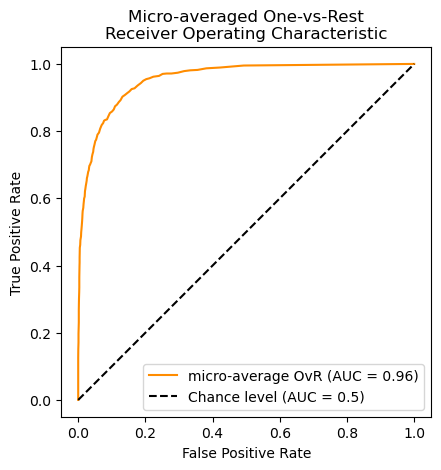

In [34]:
RocCurveDisplay.from_predictions(
    LabelBinarizer().fit_transform(y_test).ravel(),
    y_pred_proba.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()